In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pickle
import os
import pandas as pd
import json
from itertools import compress
import math

from scipy import signal 

import glob

from DataManager import ParticipantData, MeasurementData
from Helpers import read_normalized_json_to_df, save_to_disk, load_from_disk, create_rolling_windows

def intersection(lst1, lst2): 
    tup1 = map(tuple, lst1) 
    tup2 = map(tuple, lst2)  
    return list(map(list, set(tup1).intersection(tup2))) 

def reject_outliers(data, m=2):
    # create index of data
    index = list(data.index)
    # check where to remove outliers with 2 sigma distance
    outlier_bool = abs(data - np.mean(data)) < m * np.std(data)
    
    # apply to index and data and return
    return data[outlier_bool], list(compress(index, outlier_bool))

def anglebetween(v1, v2):
    v1Norm = v1/np.linalg.norm(v1)
    v2Norm = v2/np.linalg.norm(v2)
    Dot = np.dot(v1Norm, v2Norm)
    angle = math.degrees(np.arccos(Dot))
    
    return angle


In [2]:
reference_data_all_failed_save_path = "./post_recorded_reference_data/reference_dict_all.pickle"
REFERENCE_DATA_ALL_EVENTS_FAILED = load_from_disk(reference_data_all_failed_save_path)

correlation_dict_path = "./post_recorded_reference_data/corr_dict.pickle"
CORRELATION_DICT = load_from_disk(correlation_dict_path)

In [3]:
print(REFERENCE_DATA_ALL_EVENTS_FAILED["Westbrueck"][0].columns)

Index(['CarPosition.x', 'CarPosition.y', 'CarPosition.z',
       'car_rotation_angles.x', 'car_rotation_angles.y',
       'car_rotation_angles.z', 'car_rotation_direction.x',
       'car_rotation_direction.y', 'car_rotation_direction.z'],
      dtype='object')


# Load data

In [4]:
eyes_paths  = ["./data/EyeTracking/"]
input_paths = ["./data/Input/"]
calib_paths = ["./data/ParticipantCalibrationData/"]
scene_paths = ["./data/SceneData/"]


measurement1 = MeasurementData(eyes_paths,input_paths,calib_paths,scene_paths,True)


MeasurementData: Found files for participant 0bc17d704fec4a9eb892d905fc2e5da9.
Input data files: ['./data/Input/0bc17d704fec4a9eb892d905fc2e5da9_Input_Autobahn.txt', './data/Input/0bc17d704fec4a9eb892d905fc2e5da9_Input_Westbrueck.txt', './data/Input/0bc17d704fec4a9eb892d905fc2e5da9_Input_TrainingScene.txt', './data/Input/0bc17d704fec4a9eb892d905fc2e5da9_Input_MountainRoad.txt', './data/Input/0bc17d704fec4a9eb892d905fc2e5da9_Input_CountryRoad.txt']
Eyetracking data files: ['./data/EyeTracking/0bc17d704fec4a9eb892d905fc2e5da9_EyeTracking_MountainRoad.txt', './data/EyeTracking/0bc17d704fec4a9eb892d905fc2e5da9_EyeTracking_Westbrueck.txt', './data/EyeTracking/0bc17d704fec4a9eb892d905fc2e5da9_EyeTracking_TrainingScene.txt', './data/EyeTracking/0bc17d704fec4a9eb892d905fc2e5da9_EyeTracking_Autobahn.txt', './data/EyeTracking/0bc17d704fec4a9eb892d905fc2e5da9_EyeTracking_CountryRoad.txt']
Calibration data files: ['./data/ParticipantCalibrationData/0bc17d704fec4a9eb892d905fc2e5da9_ParticipantCalib

In [5]:
measurement1.apply_reference_data(REFERENCE_DATA_ALL_EVENTS_FAILED)

MeasurementData: Applying reference data to all participants...
ParticipantData: Applying reference data to back of Westbrueck's segment 0. Number of datapoints used: 2089.
ParticipantData: Applying reference data to back of Westbrueck's segment 1. Number of datapoints used: 2131.
ParticipantData: Applying reference data to back of Westbrueck's segment 2. Number of datapoints used: 1932.
ParticipantData: Applying reference data to back of Westbrueck's segment 3. Number of datapoints used: 1767.
ParticipantData: Applying reference data to back of MountainRoad's segment 0. Number of datapoints used: 1691.
ParticipantData: Applying reference data to back of MountainRoad's segment 1. Number of datapoints used: 3131.
ParticipantData: Applying reference data to back of MountainRoad's segment 2. Number of datapoints used: 4347.
ParticipantData: Applying reference data to back of MountainRoad's segment 3. Number of datapoints used: 1036.
ParticipantData: Applying reference data to back of Coun

# Filter data

In [6]:
filtered_data = measurement1.get_data(use_vanilla = False, filter_data=True, filter_by_corr_coeff_dict=CORRELATION_DICT, corr_coeff_threshold=0.95, exclude_participants=["0bc17d704fec4a9eb892d905fc2e5da9"])

print(filtered_data['0d0d7bd79b1a48d4ad5e757cdbfc15c9']["Westbrueck"][0].columns)


ParticipantData: Filtering data by Correlation Coefficients with threshold 0.95.
ParticipantData: Corr-coeff filtering excluded Westbrueck segment 2 with min corr-coeffs 0.9055197317583018.
ParticipantData: Corr-coeff filtering excluded MountainRoad segment 1 with min corr-coeffs 0.9440682544132852.
ParticipantData: Corr-coeff filtering excluded MountainRoad segment 2 with min corr-coeffs 0.4288595845461723.
ParticipantData: Corr-coeff filtering excluded CountryRoad segment 1 with min corr-coeffs 0.9378459305925257.
ParticipantData: Corr-coeff filtering excluded CountryRoad segment 2 with min corr-coeffs 0.8192290224652639.
ParticipantData: Corr-coeff filtering excluded CountryRoad segment 3 with min corr-coeffs 0.9363527740836213.
ParticipantData: Corr-coeff filtering excluded Autobahn segment 1 with min corr-coeffs 0.6856464347733652.
ParticipantData: Corr-coeff filtering excluded Autobahn segment 3 with min corr-coeffs -0.9139574552395952.
Index(['HmdPosition.x', 'HmdPosition.y', 'H

In [7]:
# Average data over multiple sessions per segment
average = measurement1.average_data(filtered_data)



## Spectral density

In [8]:
# Extract data of one participant, of one area, of one segment 
print("Available participants: " + str(measurement1.get_participant_list()))
#one_participant_single_segment = measurement1.get_data(use_vanilla=False, filter_data=True, \
#                 get_first_segment=False, after_event_type_only=[True,False], \
#                 exclude_areas=[], exclude_segments=[], \
#                 exclude_participants=['0d0d7bd79b1a48d4ad5e757cdbfc15c9'])
one_participant_single_segment = measurement1.get_data(use_vanilla=False, filter_data=True, \
                 filter_by_corr_coeff_dict=CORRELATION_DICT, corr_coeff_threshold=0.95, \
                 exclude_participants=['0d0d7bd79b1a48d4ad5e757cdbfc15c9'])
one_participant_single_segment = one_participant_single_segment['0bc17d704fec4a9eb892d905fc2e5da9']["Westbrueck"][1]

# Average data over multiple sessions per segment
average_over_all_participants = measurement1.get_data(use_vanilla = False, filter_data=True, filter_by_corr_coeff_dict=CORRELATION_DICT, corr_coeff_threshold=0.95, exclude_participants=[])
average_over_all_participants = measurement1.average_data(average_over_all_participants)
average_over_all_participants_single_segment = average_over_all_participants["Westbrueck"][0]


Available participants: ['0bc17d704fec4a9eb892d905fc2e5da9', '0d0d7bd79b1a48d4ad5e757cdbfc15c9']
ParticipantData: Filtering data by Correlation Coefficients with threshold 0.95.
ParticipantData: Corr-coeff filtering excluded Westbrueck segment 2 with min corr-coeffs 0.9055197317583018.
ParticipantData: Corr-coeff filtering excluded MountainRoad segment 1 with min corr-coeffs 0.9440682544132852.
ParticipantData: Corr-coeff filtering excluded MountainRoad segment 2 with min corr-coeffs 0.4288595845461723.
ParticipantData: Corr-coeff filtering excluded CountryRoad segment 1 with min corr-coeffs 0.9378459305925257.
ParticipantData: Corr-coeff filtering excluded CountryRoad segment 2 with min corr-coeffs 0.8192290224652639.
ParticipantData: Corr-coeff filtering excluded CountryRoad segment 3 with min corr-coeffs 0.9363527740836213.
ParticipantData: Corr-coeff filtering excluded Autobahn segment 1 with min corr-coeffs 0.6856464347733652.
ParticipantData: Corr-coeff filtering excluded Autobah

/Users/stefan/opt/anaconda3/envs/Body2Eye/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  warnings.warn(


In [9]:
one_participant_single_segment

,HmdPosition.x,HmdPosition.y,HmdPosition.z,NoseVector.x,NoseVector.y,NoseVector.z,EyePosWorldCombined.x,EyePosWorldCombined.y,EyePosWorldCombined.z,EyeDirWorldCombined.x,EyeDirWorldCombined.y,EyeDirWorldCombined.z,resampled_timestamp,is_interpolated
0,0.250366,1.034218,-0.322266,0.111161,0.260637,-0.379572,0.265152,1.036537,-0.292114,0.097806,-0.018451,-0.418073,3.53,False
1,0.297546,1.032471,-0.302368,0.111703,0.260861,-0.380412,0.313370,1.034637,-0.275513,0.098264,-0.020238,-0.418647,3.54,False
2,0.296974,1.032562,-0.305298,-0.878876,-0.257737,-1.256208,0.312607,1.034660,-0.277344,-0.892490,-0.538813,-1.294377,3.55,True
3,0.296402,1.032654,-0.308228,0.108135,0.261078,-0.371654,0.311844,1.034683,-0.279175,0.094346,-0.019977,-0.409757,3.56,False
4,0.295753,1.032654,-0.313354,0.104049,0.261644,-0.361294,0.313454,1.034454,-0.291138,0.094666,-0.016856,-0.410164,3.57,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2126,0.251198,1.042816,-0.401978,0.050449,0.358834,-0.020351,0.271111,1.044968,-0.371948,0.068000,0.150216,-0.308683,24.79,False
2127,0.254776,1.042587,-0.400513,0.050931,0.358854,-0.026439,0.274292,1.044609,-0.375488,0.069367,0.144494,-0.313999,24.80,True
2128,0.317627,1.038681,-0.381226,0.051421,0.358862,-0.032689,0.336746,1.040573,-0.361206,0.070742,0.138761,-0.319478,24.81,False
2129,0.264313,1.041924,-0.396118,0.052026,0.359144,-0.038615,0.282814,1.043701,-0.382446,0.072137,0.139934,-0.322710,24.82,True


# Comparing vanilla & reference data applied & reference data

In [10]:
# Extract data of one participant, of one area, of one segment without ref data applied 
one_participant_single_segment_no_ref_applied = measurement1.get_data(use_vanilla=True, filter_data=True, \
                 filter_by_corr_coeff_dict=CORRELATION_DICT, corr_coeff_threshold=0.95, \
                 exclude_participants=['0d0d7bd79b1a48d4ad5e757cdbfc15c9'])
one_participant_single_segment_no_ref_applied = one_participant_single_segment_no_ref_applied['0bc17d704fec4a9eb892d905fc2e5da9']["Westbrueck"][1]

ref_data_one_participant_single_segment = REFERENCE_DATA_ALL_EVENTS_FAILED["Westbrueck"][1]

ParticipantData: Filtering data by Correlation Coefficients with threshold 0.95.
ParticipantData: Corr-coeff filtering excluded Westbrueck segment 2 with min corr-coeffs 0.9055197317583018.
ParticipantData: Corr-coeff filtering excluded MountainRoad segment 1 with min corr-coeffs 0.9440682544132852.
ParticipantData: Corr-coeff filtering excluded MountainRoad segment 2 with min corr-coeffs 0.4288595845461723.
ParticipantData: Corr-coeff filtering excluded CountryRoad segment 1 with min corr-coeffs 0.9378459305925257.
ParticipantData: Corr-coeff filtering excluded CountryRoad segment 2 with min corr-coeffs 0.8192290224652639.
ParticipantData: Corr-coeff filtering excluded CountryRoad segment 3 with min corr-coeffs 0.9363527740836213.
ParticipantData: Corr-coeff filtering excluded Autobahn segment 1 with min corr-coeffs 0.6856464347733652.
ParticipantData: Corr-coeff filtering excluded Autobahn segment 3 with min corr-coeffs -0.9139574552395952.


In [11]:
ref_data_one_participant_single_segment.columns

Index(['CarPosition.x', 'CarPosition.y', 'CarPosition.z',
       'car_rotation_angles.x', 'car_rotation_angles.y',
       'car_rotation_angles.z', 'car_rotation_direction.x',
       'car_rotation_direction.y', 'car_rotation_direction.z'],
      dtype='object')

In [12]:
one_participant_single_segment_no_ref_applied.columns

Index(['HmdPosition.x', 'HmdPosition.y', 'HmdPosition.z', 'NoseVector.x',
       'NoseVector.y', 'NoseVector.z', 'EyePosWorldCombined.x',
       'EyePosWorldCombined.y', 'EyePosWorldCombined.z',
       'EyeDirWorldCombined.x', 'EyeDirWorldCombined.y',
       'EyeDirWorldCombined.z', 'EyePosLocalCombined.x',
       'EyePosLocalCombined.y', 'EyePosLocalCombined.z',
       'EyeDirLocalCombined.x', 'EyeDirLocalCombined.y',
       'EyeDirLocalCombined.z', 'resampled_timestamp', 'is_interpolated'],
      dtype='object')

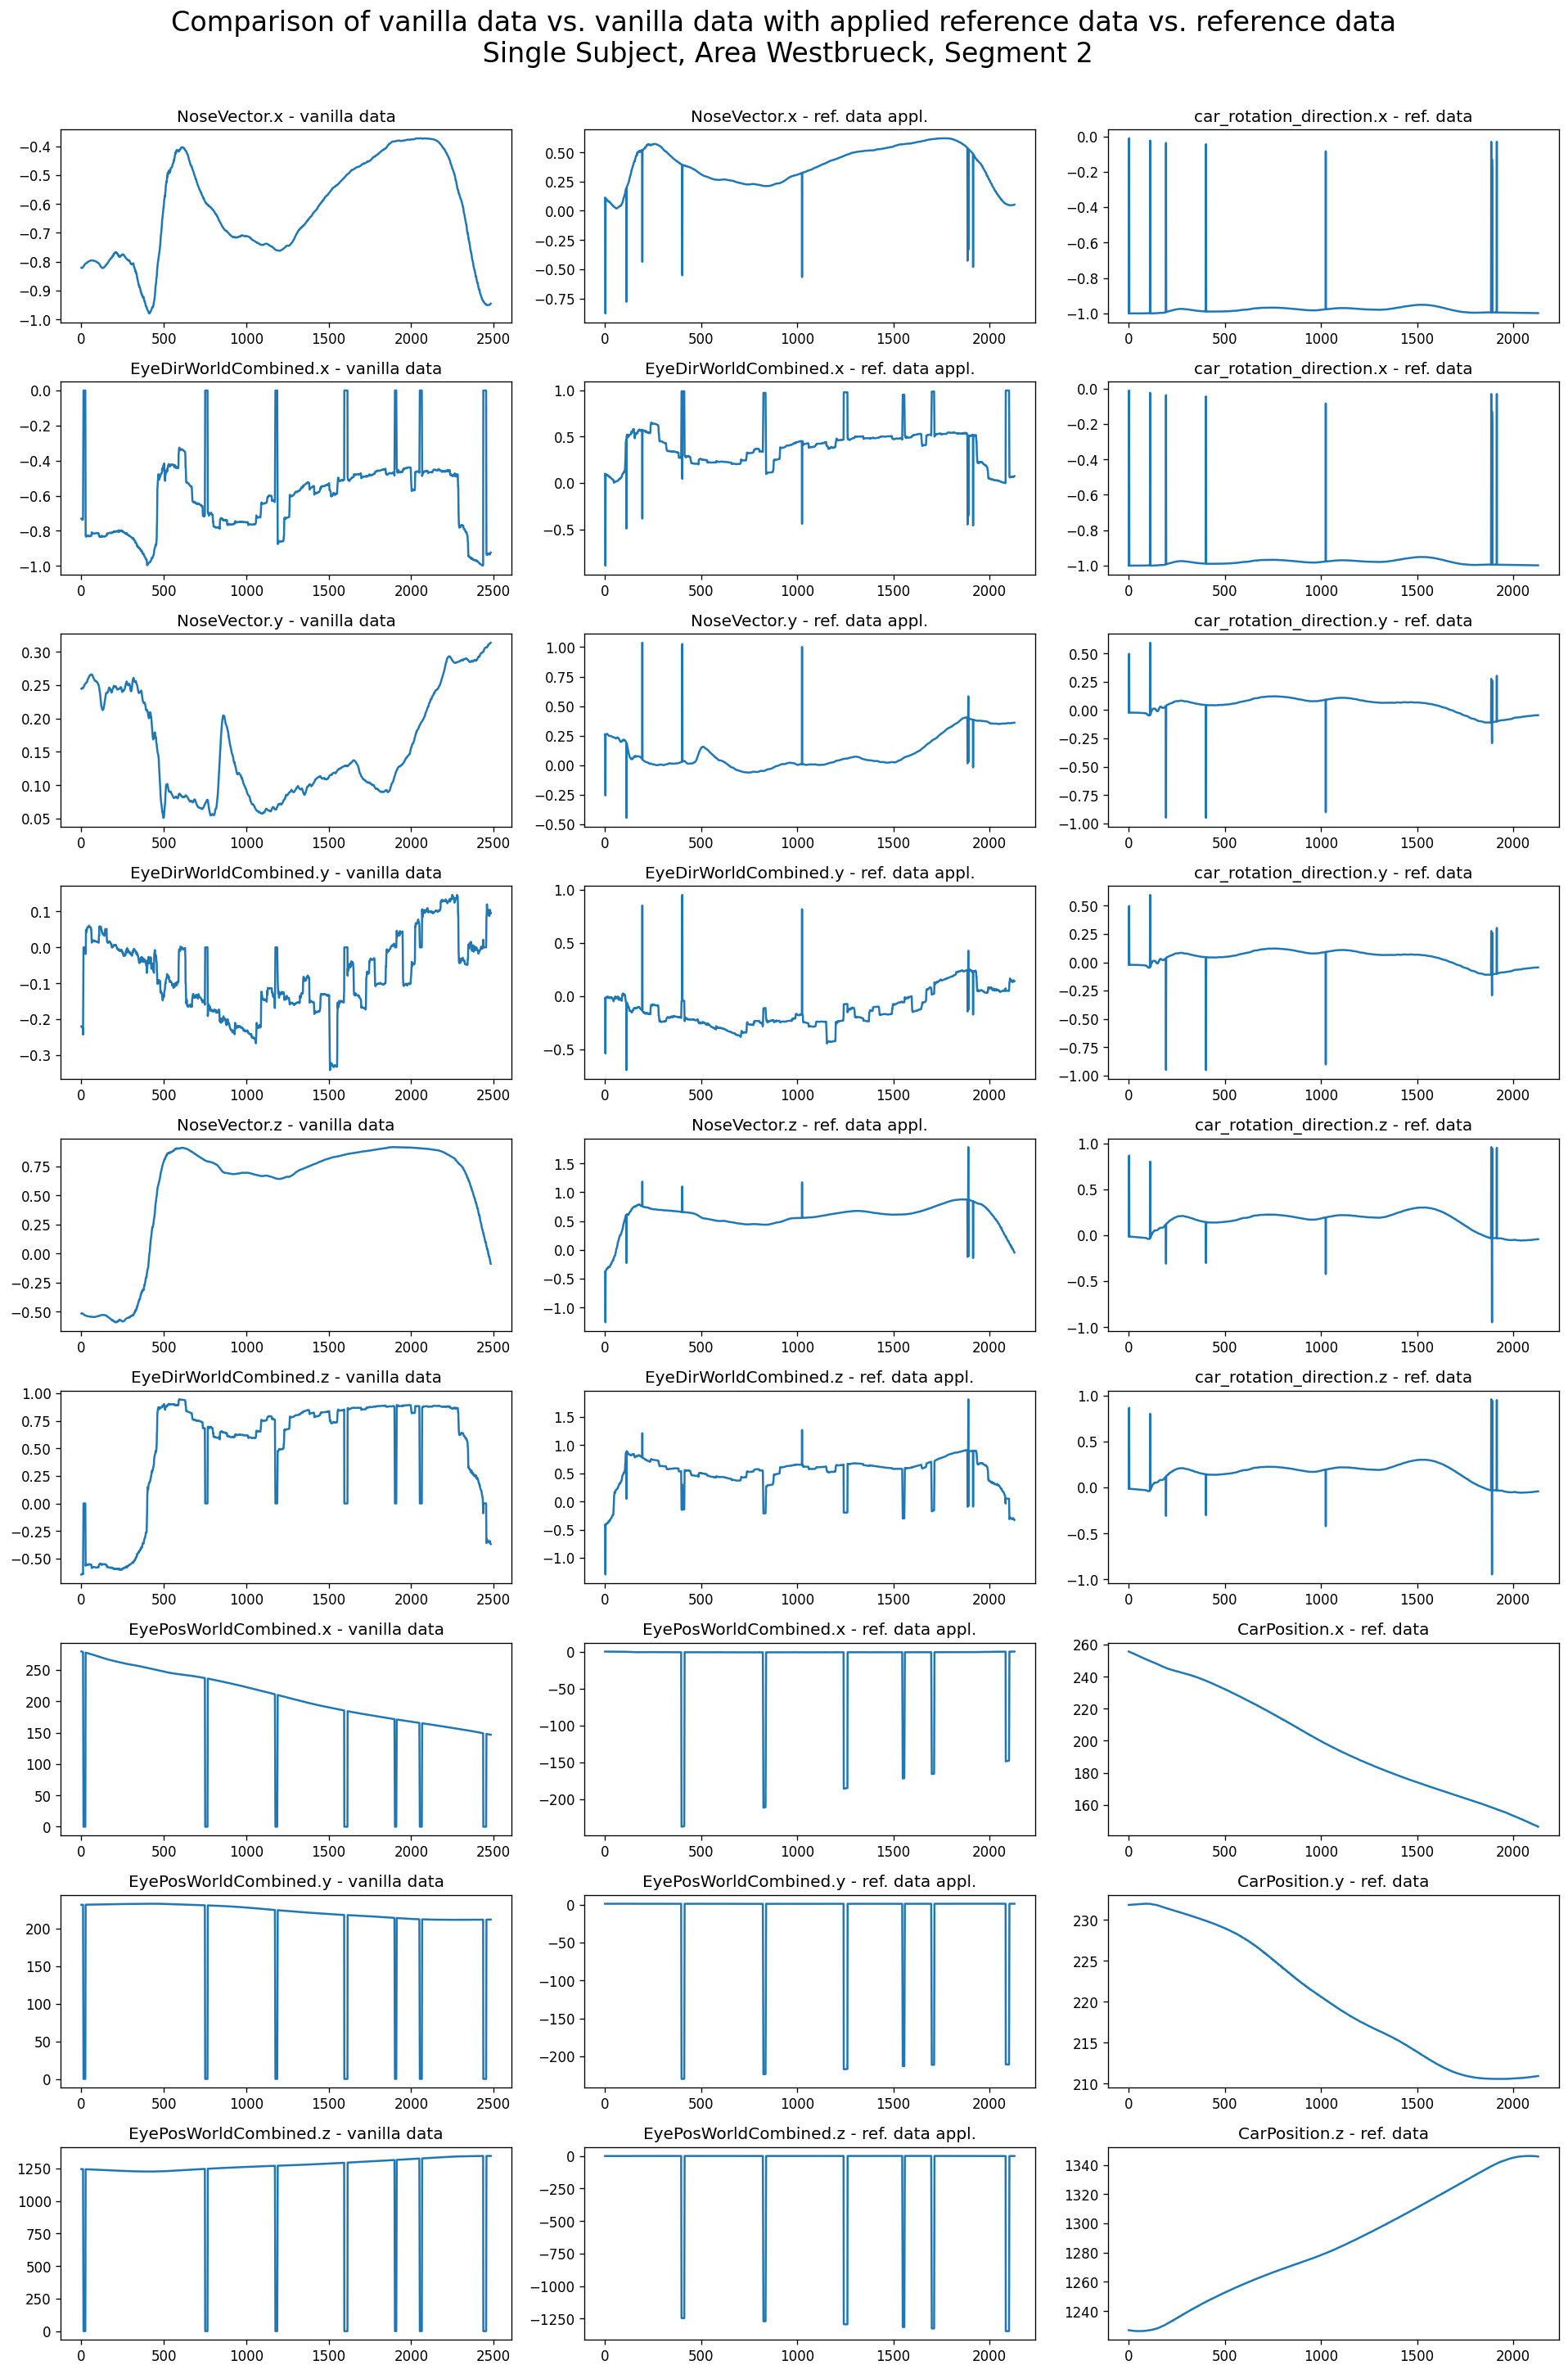

In [13]:
# plot comparison 

fig, ax = plt.subplots(nrows=9, ncols=3, figsize=(16,24), dpi=120)

names_x = ["NoseVector.x","NoseVector.x",'car_rotation_direction.x',"EyeDirWorldCombined.x","EyeDirWorldCombined.x",'car_rotation_direction.x', \
           "NoseVector.y","NoseVector.y",'car_rotation_direction.y',"EyeDirWorldCombined.y","EyeDirWorldCombined.y",'car_rotation_direction.y', \
           "NoseVector.z","NoseVector.z",'car_rotation_direction.z',"EyeDirWorldCombined.z","EyeDirWorldCombined.z",'car_rotation_direction.z', \
           'EyePosWorldCombined.x','EyePosWorldCombined.x','CarPosition.x', \
           'EyePosWorldCombined.y','EyePosWorldCombined.y','CarPosition.y', \
           'EyePosWorldCombined.z','EyePosWorldCombined.z','CarPosition.z'
          ]




for idx, row in enumerate(ax.reshape(-1)):
    
    if idx % 3 == 0:
        
        x = one_participant_single_segment_no_ref_applied[names_x[idx]]
        row.plot(x)
        row.set_title(names_x[idx] + " - vanilla data")
        
    elif idx % 3 == 1:
        
        x = one_participant_single_segment[names_x[idx]]
        row.plot(x)
        row.set_title(names_x[idx] + " - ref. data appl.")
    
    elif idx % 3 == 2:
        
        x = ref_data_one_participant_single_segment[names_x[idx]]
        row.plot(x)
        row.set_title(names_x[idx] + " - ref. data")


fig.suptitle("Comparison of vanilla data vs. vanilla data with applied reference data vs. reference data \n Single Subject, Area Westbrueck, Segment 2 ",fontsize=20, y=1.005)
    
fig.tight_layout()
plt.show()

In [14]:
ref_data_one_participant_single_segment

,CarPosition.x,CarPosition.y,CarPosition.z,car_rotation_angles.x,car_rotation_angles.y,car_rotation_angles.z,car_rotation_direction.x,car_rotation_direction.y,car_rotation_direction.z
0,255.688675,231.815132,1226.958130,357.517685,238.914680,0.025810,-0.999696,-0.021532,-0.012008
1,255.641785,231.816971,1226.937988,357.536865,239.265717,-0.002563,-0.999694,-0.021504,-0.012248
2,255.592041,231.818939,1226.917053,357.540726,239.620895,179.970627,-0.010893,0.497100,0.867625
3,255.542297,231.820908,1226.896118,357.544586,239.976074,359.943817,-0.999682,-0.021707,-0.012853
4,255.439110,231.824936,1226.855103,357.540634,240.704323,359.900284,-0.999668,-0.021968,-0.013435
...,...,...,...,...,...,...,...,...,...
2126,146.618660,210.896515,1345.838379,356.403992,261.380768,358.082993,-0.998001,-0.045706,-0.043655
2127,146.562592,210.899963,1345.822754,356.384949,260.998413,358.104462,-0.998015,-0.045616,-0.043428
2128,146.447250,210.907089,1345.789307,356.340271,260.244141,358.145905,-0.998036,-0.045515,-0.043039
2129,146.447250,210.907089,1345.789307,356.340271,260.244141,358.145905,-0.998036,-0.045515,-0.043039


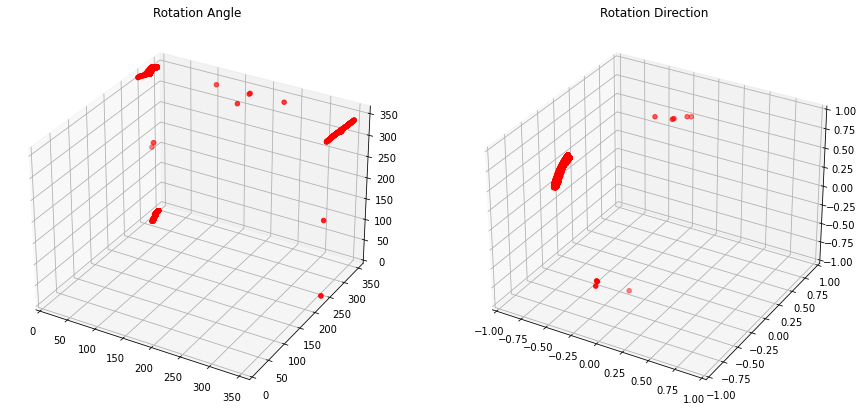

In [15]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(1,2,1, projection='3d')

x = ref_data_one_participant_single_segment['car_rotation_angles.x']
y =ref_data_one_participant_single_segment['car_rotation_angles.y']
z =ref_data_one_participant_single_segment['car_rotation_angles.z']

ax1.set_xlim([0,360])
ax1.set_ylim([0,360])
ax1.set_zlim([0,360])
ax1.set_title('Rotation Angle')

ax1.scatter(x, y, z, c='r', marker='o')

ax2 = fig.add_subplot(1,2,2, projection='3d')

x = ref_data_one_participant_single_segment['car_rotation_direction.x']
y =ref_data_one_participant_single_segment['car_rotation_direction.y']
z =ref_data_one_participant_single_segment['car_rotation_direction.z']

ax2.set_xlim([-1,1])
ax2.set_ylim([-1,1])
ax2.set_zlim([-1,1])
ax2.set_title('Rotation Direction')

ax2.scatter(x, y, z, c='r', marker='o')

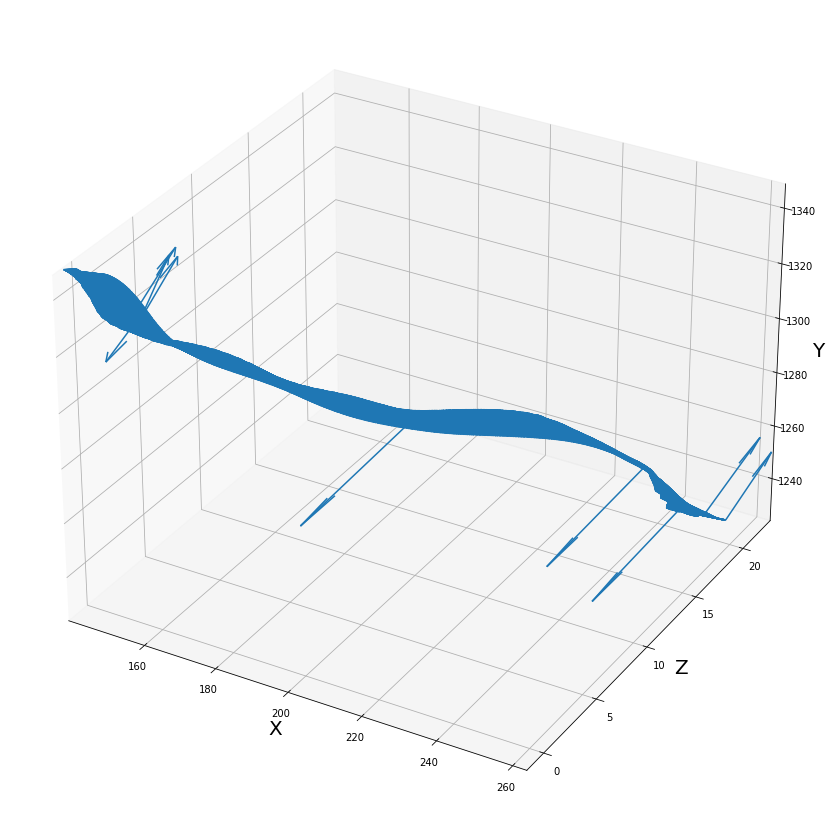

In [16]:
import matplotlib as matplotlib

carPos_x = ref_data_one_participant_single_segment['CarPosition.x']#[:100]
carPos_y = ref_data_one_participant_single_segment['CarPosition.y']#[:100]
carPos_y = carPos_y - min(carPos_y)
carPos_z = ref_data_one_participant_single_segment['CarPosition.z']#[:100]

carRot_x = ref_data_one_participant_single_segment['car_rotation_direction.x']#[:100]
carRot_y = ref_data_one_participant_single_segment['car_rotation_direction.y']#[:100]
carRot_z = ref_data_one_participant_single_segment['car_rotation_direction.z']#[:100]

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')

ax.quiver(carPos_x,carPos_y,carPos_z,carRot_x,carRot_y,carRot_z, length=10)

ax.set_xlabel('X', fontsize=20)
ax.set_ylabel('Z', fontsize=20)
ax.set_zlabel('Y', fontsize=20)

#ax.set_xlim([min(carPos_x),max(carPos_x)])
#ax.set_ylim([1280,1350])
#ax.set_zlim([min(carPos_z),max(carPos_z)])

plt.draw()
plt.show()

# Raw Participant Data (ref. data applied) - Nose Vector and Eye Dir Vector

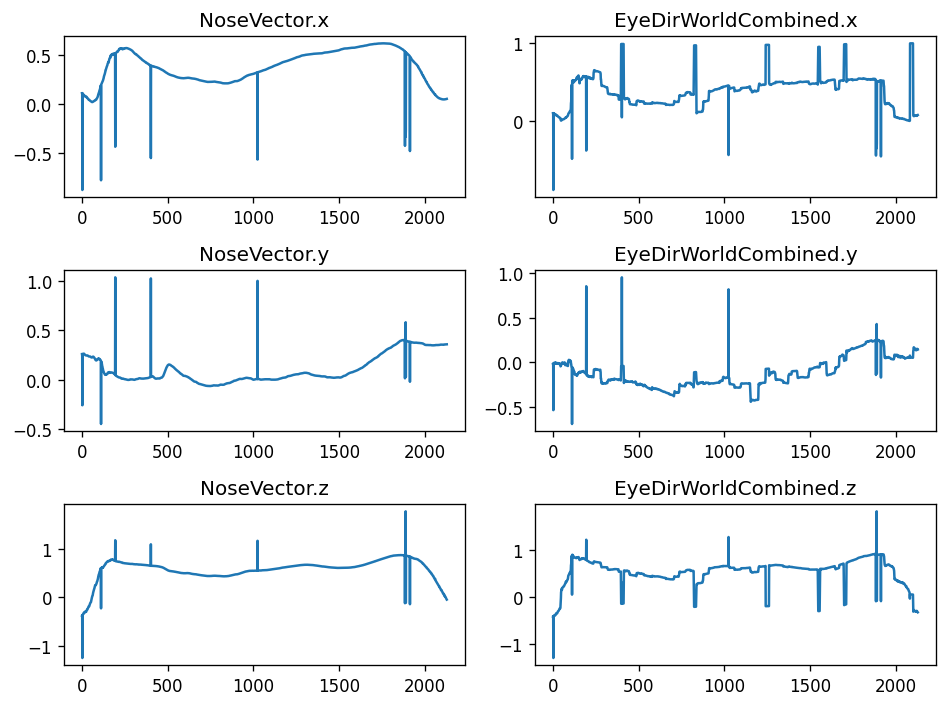

In [21]:
# testing to remove outliers from the angles of nose and eye direction
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(8,6), dpi=120)

names_x = ["NoseVector.x","EyeDirWorldCombined.x","NoseVector.y","EyeDirWorldCombined.y","NoseVector.z","EyeDirWorldCombined.z"]


for idx, row in enumerate(ax.reshape(-1)):
    x = one_participant_single_segment[names_x[idx]]
    
    row.plot(x)
    row.set_title(names_x[idx])

    
fig.tight_layout()
plt.show()

# Power Spectral Density on raw data (ref. data applied)

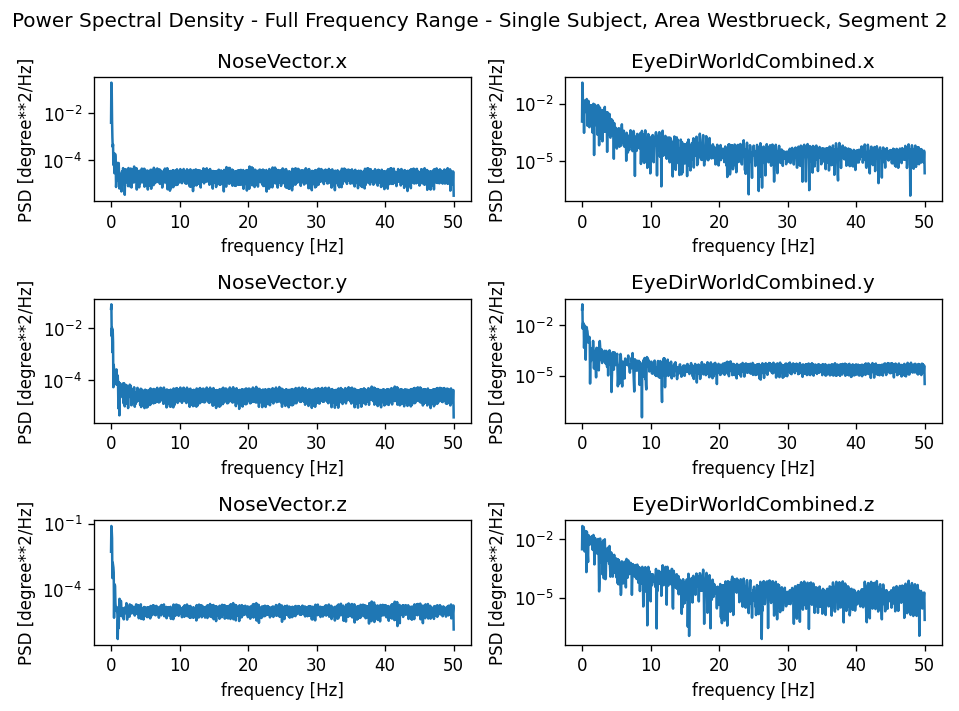

In [22]:
# power spectral density using welch's method, full frequency range 

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(8,6), dpi=120)

names_x = ["NoseVector.x","EyeDirWorldCombined.x","NoseVector.y","EyeDirWorldCombined.y","NoseVector.z","EyeDirWorldCombined.z"]

for idx, row in enumerate(ax.reshape(-1)):
    x = one_participant_single_segment[names_x[idx]]
    f, pxx_den = signal.welch(x,fs=(1/0.01),nperseg=2048)
    row.semilogy(f, pxx_den)
    #row.set_ylim([0.5e-3, 100])
    #row.set_xlim([0, 2])
    row.set_xlabel('frequency [Hz]')
    row.set_ylabel('PSD [degree**2/Hz]')
    row.set_title(names_x[idx])

fig.suptitle("Power Spectral Density - Full Frequency Range - Single Subject, Area Westbrueck, Segment 2")
fig.tight_layout()
plt.show()

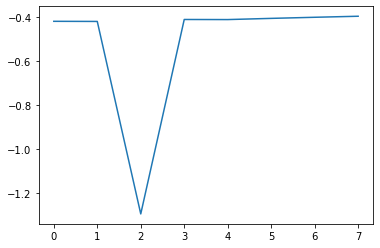

In [23]:
plt.plot(one_participant_single_segment[names_x[idx]][0:8])

In [24]:
# TODO: fix this 
######## 
names_x = ["NoseVector.x","EyeDirWorldCombined.x","NoseVector.y","EyeDirWorldCombined.y","NoseVector.z","EyeDirWorldCombined.z"]
idx = 0
########

v1_list = one_participant_single_segment[['EyeDirWorldCombined.x', 'EyeDirWorldCombined.y', 'EyeDirWorldCombined.z']]
#v1_list = v1_list[:len(v1_list)]
v1_list = v1_list.reset_index(drop=True)
v2_list =  one_participant_single_segment[['NoseVector.x', 'NoseVector.y', 'NoseVector.z']]#.shift()
#v2_list = v2_list[1:]
v2_list = v2_list.reset_index(drop=True)

#### TODO: fix this 
#### names_x & idx 
x = one_participant_single_segment[names_x[idx]]
x_out, index = reject_outliers(x)
    
    

angles_EyeDir = []

for idx in range(len(v1_list)-1):
    
    v1 = []
    v1.append(v1_list.loc[idx, 'EyeDirWorldCombined.x'])
    v1.append(v1_list.loc[idx, 'EyeDirWorldCombined.y'])
    v1.append(v1_list.loc[idx, 'EyeDirWorldCombined.z'])
    
    #v1 = np.array(v1)
    
    v2 = []
    v2.append(v2_list.loc[idx, 'NoseVector.x'])
    v2.append(v2_list.loc[idx, 'NoseVector.y'])
    v2.append(v2_list.loc[idx, 'NoseVector.z'])
    
    #v2 = np.array(v2)
    
    angles_EyeDir.append(anglebetween(v1, v2))




# Rearranging the angles from [0, 360] to [-180, 180] - OBSOLETE

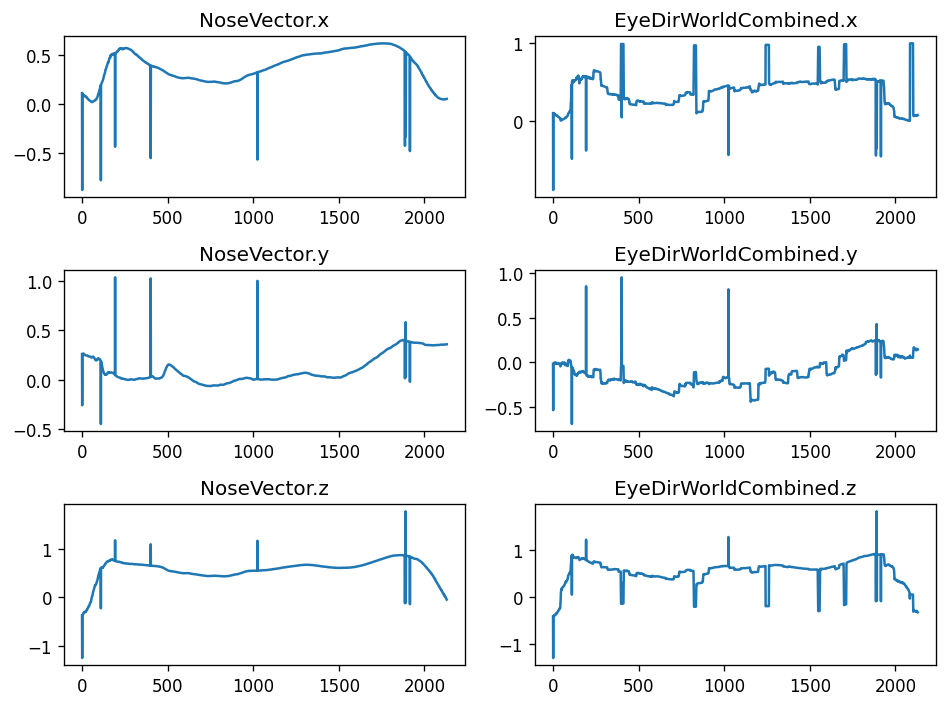

In [25]:
# testing to remove outliers from the angles of nose and eye direction
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(8,6), dpi=120)

names_x = ["NoseVector.x","EyeDirWorldCombined.x","NoseVector.y","EyeDirWorldCombined.y","NoseVector.z","EyeDirWorldCombined.z"]

for idx, row in enumerate(ax.reshape(-1)):
    x = ((one_participant_single_segment[names_x[idx]][1:] - 180) % 360) - 180
    
    row.plot(x)
    row.set_title(names_x[idx])

    
fig.tight_layout()
plt.show()

# Removing outliers (2 sigma)

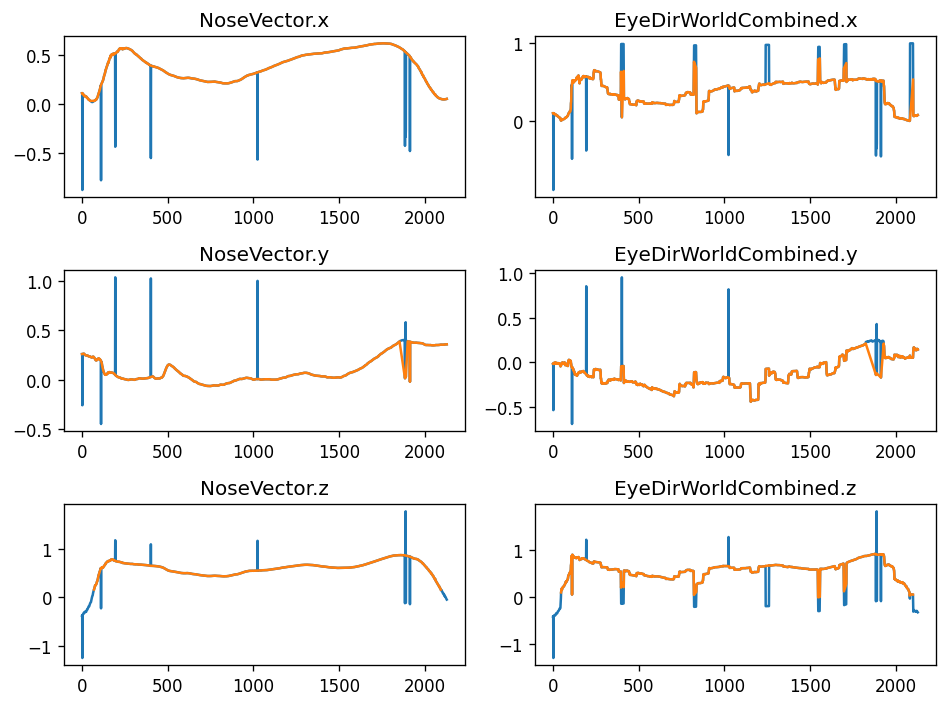

In [26]:
# testing to remove outliers from the angles of nose and eye direction
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(8,6), dpi=120)

names_x = ["NoseVector.x","EyeDirWorldCombined.x","NoseVector.y","EyeDirWorldCombined.y","NoseVector.z","EyeDirWorldCombined.z"]

for idx, row in enumerate(ax.reshape(-1)):
    x = one_participant_single_segment[names_x[idx]]
    x_out, index = reject_outliers(x)
    
    row.plot(x)
    row.plot(x_out)
    
    row.set_title(names_x[idx])
    
fig.tight_layout()
plt.show()

# Checking for data similarity (Nose to Eye - before and after cleaning)

In [27]:
names_x = ["NoseVector.x", "NoseVector.y","NoseVector.z"]
names_y = ["EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z"]


print('Correlations before post-processing:')
for idx in range(len(names_x)):
    x = one_participant_single_segment[names_x[idx]][1:]
    y = one_participant_single_segment[names_y[idx]][1:]
    print('\t' 
          + names_x[idx] 
          + ' - ' 
          + names_y[idx] 
          + ': '
          + str(np.corrcoef(x,y)[0,0]))
    
    
print('Correlations after angular adjustment and outlier removing:')
for idx in range(len(names_x)):
    
    x = ((one_participant_single_segment[names_x[idx]][1:] - 180) % 360) - 180
    x, xindex = reject_outliers(x)
    
    y = ((one_participant_single_segment[names_y[idx]][1:] - 180) % 360) - 180
    y, yindex = reject_outliers(y)

    index_intersection = list(set(xindex).intersection(yindex))
    
    print('\t' 
          + names_x[idx] 
          + ' - ' 
          + names_y[idx] 
          + ': '
          + str(np.corrcoef(x[index_intersection],y[index_intersection])[0,0]))
    

Correlations before post-processing:
	NoseVector.x - EyeDirWorldCombined.x: 1.0
	NoseVector.y - EyeDirWorldCombined.y: 1.0
	NoseVector.z - EyeDirWorldCombined.z: 0.9999999999999999
Correlations after angular adjustment and outlier removing:
	NoseVector.x - EyeDirWorldCombined.x: 1.0
	NoseVector.y - EyeDirWorldCombined.y: 0.9999999999999999
	NoseVector.z - EyeDirWorldCombined.z: 0.9999999999999998


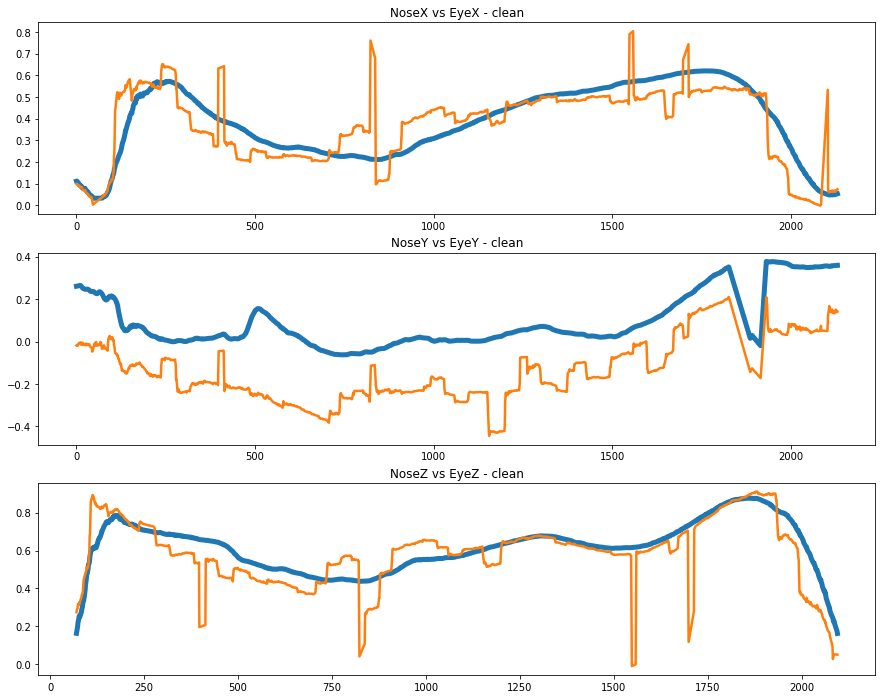

In [28]:
# X

NoseX = one_participant_single_segment['NoseVector.x'] 
NoseX, noseXindex = reject_outliers(NoseX)

EyeX = one_participant_single_segment['EyeDirWorldCombined.x'] 
EyeX, eyeXindex = reject_outliers(EyeX)

X_index_intersection = list(set(noseXindex).intersection(eyeXindex))

# Y

NoseY = one_participant_single_segment['NoseVector.y']
NoseY, noseYindex = reject_outliers(NoseY)

EyeY = one_participant_single_segment['EyeDirWorldCombined.y']
EyeY, eyeYindex = reject_outliers(EyeY)

Y_index_intersection = list(set(noseYindex).intersection(eyeYindex))

# Z

NoseZ = one_participant_single_segment['NoseVector.z']
NoseZ, noseZindex = reject_outliers(NoseZ)

EyeZ = one_participant_single_segment['EyeDirWorldCombined.z']
EyeZ, eyeZindex = reject_outliers(EyeZ)

Z_index_intersection = list(set(noseZindex).intersection(eyeZindex))


# Plot 
plt.figure(figsize=(15,12))
plt.subplot(3,1,1)
plt.title('NoseX vs EyeX - clean')
plt.plot(NoseX[X_index_intersection], linewidth=5)
plt.plot(EyeX[X_index_intersection], linewidth=2.5)

plt.subplot(3,1,2)
plt.title('NoseY vs EyeY - clean')
plt.plot(NoseY[Y_index_intersection], linewidth=5)
plt.plot(EyeY[Y_index_intersection], linewidth=2.5)

plt.subplot(3,1,3)
plt.title('NoseZ vs EyeZ - clean')
plt.plot(NoseZ[Z_index_intersection], linewidth=5)
plt.plot(EyeZ[Z_index_intersection], linewidth=2.5)

# Power Spectral density on cleaned data

/Users/stefan/opt/anaconda3/envs/Body2Eye/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 2048 is greater than input length  = 2036, using nperseg = 2036
  warnings.warn('nperseg = {0:d} is greater than input length '
/Users/stefan/opt/anaconda3/envs/Body2Eye/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 2048 is greater than input length  = 2025, using nperseg = 2025
  warnings.warn('nperseg = {0:d} is greater than input length '
/Users/stefan/opt/anaconda3/envs/Body2Eye/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 2048 is greater than input length  = 2018, using nperseg = 2018
  warnings.warn('nperseg = {0:d} is greater than input length '
/Users/stefan/opt/anaconda3/envs/Body2Eye/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 2048 is greater than input length  = 1980, using nperseg = 1980
  warnings.warn('nperseg = {0:d} is greater than input l

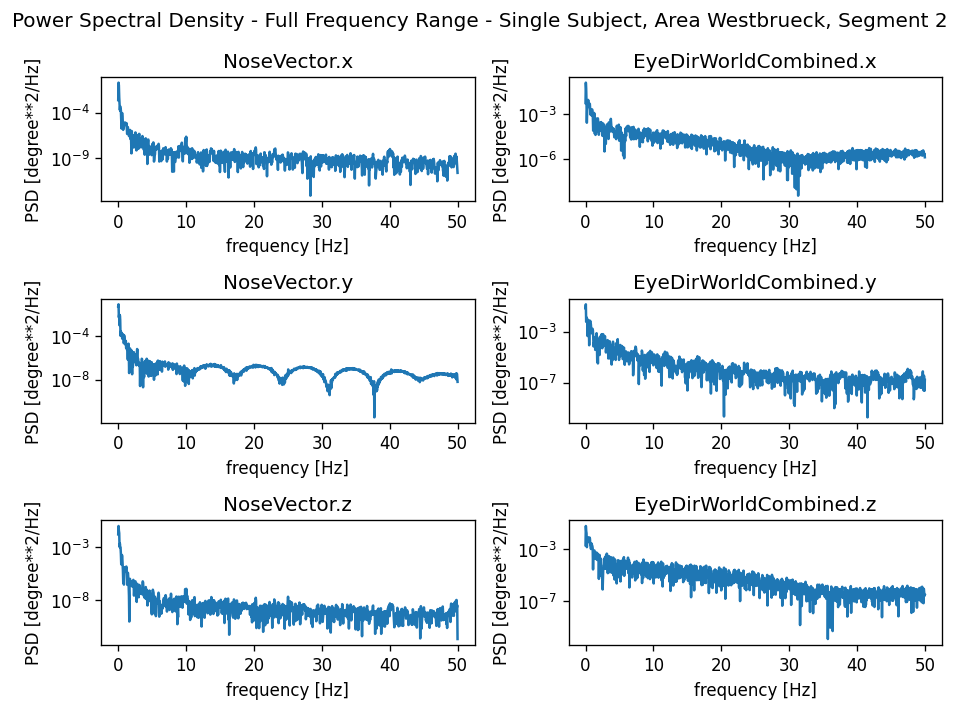

In [29]:
# power spectral density using welch's method, full frequency range 

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(8,6), dpi=120)

names_x = ["NoseVector.x","EyeDirWorldCombined.x","NoseVector.y","EyeDirWorldCombined.y","NoseVector.z","EyeDirWorldCombined.z"]

for idx, row in enumerate(ax.reshape(-1)):
    x = one_participant_single_segment[names_x[idx]]
    x, xindex = reject_outliers(x)
    f, pxx_den = signal.welch(x,fs=(1/0.01),nperseg=2048)
    row.semilogy(f, pxx_den)
    #row.set_ylim([0.5e-3, 100])
    #row.set_xlim([0, 2])
    row.set_xlabel('frequency [Hz]')
    row.set_ylabel('PSD [degree**2/Hz]')
    row.set_title(names_x[idx])

fig.suptitle("Power Spectral Density - Full Frequency Range - Single Subject, Area Westbrueck, Segment 2")
fig.tight_layout()
plt.show()

In [30]:
np.corrcoef(one_participant_single_segment['NoseVector.y'], one_participant_single_segment['EyeDirWorldCombined.y'])

#plt.hist(one_participant_single_segment['NoseVector.x'] - one_participant_single_segment['EyeDirWorldCombined.x'])

hmdX = ((one_participant_single_segment['HmdPosition.x'][1:] - 180) % 360) - 180
hmdX, hmdx_index = reject_outliers(hmdX)
hmdY = ((one_participant_single_segment['HmdPosition.y'][1:] - 180) % 360) - 180
hmdY, hmdy_index = reject_outliers(hmdY)
hmdZ = ((one_participant_single_segment['HmdPosition.z'][1:] - 180) % 360) - 180
hmdZ, hmdz_index = reject_outliers(hmdZ)

NoseX = ((one_participant_single_segment['NoseVector.x'][1:] - 180) % 360) - 180
NoseX, noseXindex = reject_outliers(NoseX)
NoseY = ((one_participant_single_segment['NoseVector.y'][1:] - 180) % 360) - 180
NoseY, noseYindex = reject_outliers(NoseY)
NoseZ = ((one_participant_single_segment['NoseVector.z'][1:] - 180) % 360) - 180
NoseZ, noseZindex = reject_outliers(NoseZ)

EyeX = ((one_participant_single_segment['EyeDirWorldCombined.x'][1:] - 180) % 360) - 180
EyeX, eyeXindex = reject_outliers(EyeX)
EyeY = ((one_participant_single_segment['EyeDirWorldCombined.y'][1:] - 180) % 360) - 180
EyeY, eyeYindex = reject_outliers(EyeY)
EyeZ = ((one_participant_single_segment['EyeDirWorldCombined.z'][1:] - 180) % 360) - 180
EyeZ, eyeZindex = reject_outliers(EyeZ)

noseXeyeX_intersection = list(set(noseXindex).intersection(eyeXindex))
nose_intersection = list(set(noseXindex).intersection(noseZindex))
eye_intersection = list(set(eyeXindex).intersection(eyeZindex))

print(np.corrcoef(NoseX,EyeX))

print(np.max(EyeX))

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title('Nose - X to Z')
plt.scatter(NoseX[nose_intersection], NoseZ[nose_intersection])
plt.subplot(2,2,2)
plt.title('Eye - X to Z')
plt.scatter(EyeX[eye_intersection], EyeZ[eye_intersection])
plt.subplot(2,2,3)
plt.title('Nose X to Eye X')
plt.scatter(NoseX, EyeX)
plt.subplot(2,2,4)
plt.title('Nose X minus Eye X')
plt.plot(NoseX[noseXeyeX_intersection]-EyeX[noseXeyeX_intersection])



ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 2098 and the array at index 1 has size 2035

In [31]:
x = ((average_over_all_participants_single_segment[names_x[idx]][1:] - 180) % 360) - 180
x, index = reject_outliers(x)

x = ((average_over_all_participants_single_segment['NoseVector.x'][1:] - 180) % 360) - 180
x, index = reject_outliers(x)
f_Nose, pxx_den_Nose = signal.welch(x, fs=(1/0.01),nperseg=2048)
    
x = ((average_over_all_participants_single_segment['EyeDirWorldCombined.x'][1:] - 180) % 360) - 180
x = reject_outliers(x)
f_Eye, pxx_den_Eye = signal.welch(x ,fs=(1/0.01),nperseg=2048)


#plt.figure(figsize=(10,10))

#plt.semilogy(f, pxx_den_Nose)#/pxx_den_Eye) 




/Users/stefan/opt/anaconda3/envs/Body2Eye/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 2048 is greater than input length  = 1944, using nperseg = 1944
  warnings.warn('nperseg = {0:d} is greater than input length '


/Users/stefan/opt/anaconda3/envs/Body2Eye/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 2048 is greater than input length  = 2036, using nperseg = 2036
  warnings.warn('nperseg = {0:d} is greater than input length '
/Users/stefan/opt/anaconda3/envs/Body2Eye/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 2048 is greater than input length  = 2025, using nperseg = 2025
  warnings.warn('nperseg = {0:d} is greater than input length '
/Users/stefan/opt/anaconda3/envs/Body2Eye/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 2048 is greater than input length  = 2018, using nperseg = 2018
  warnings.warn('nperseg = {0:d} is greater than input length '
/Users/stefan/opt/anaconda3/envs/Body2Eye/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 2048 is greater than input length  = 1980, using nperseg = 1980
  warnings.warn('nperseg = {0:d} is greater than input l

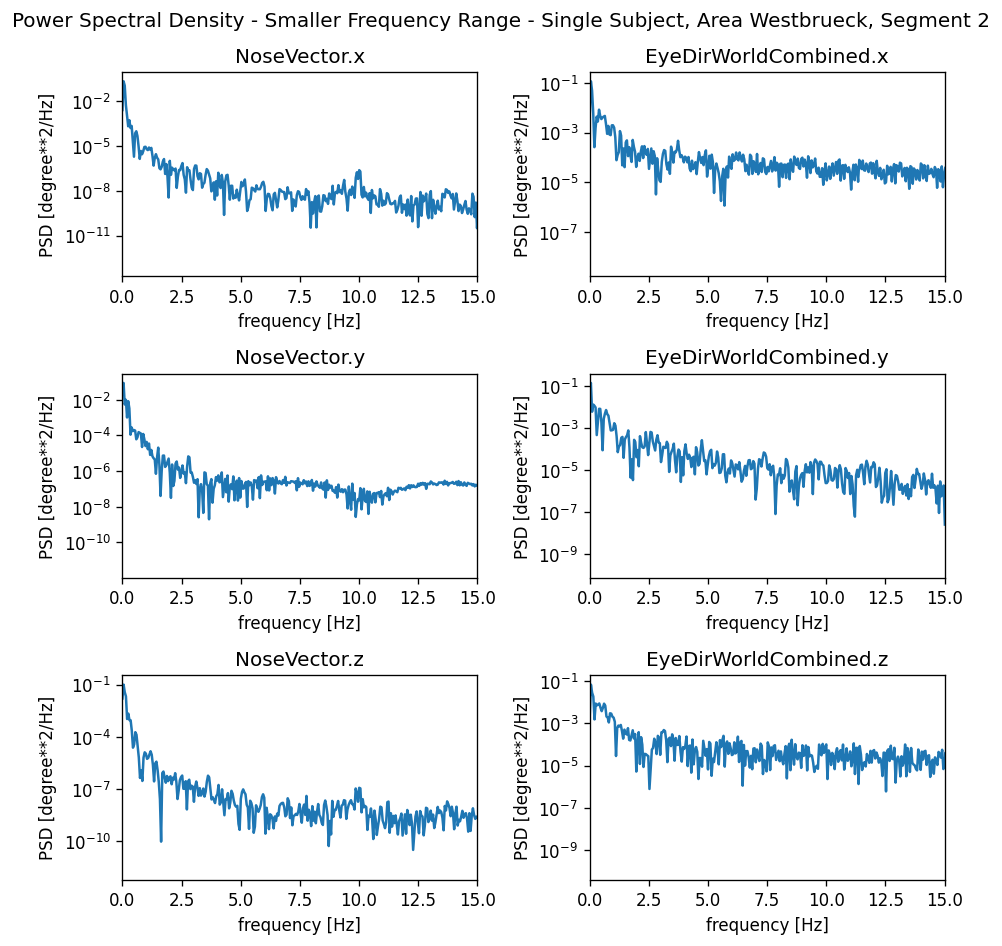

In [32]:
# power spectral density using welch's method, smaller frequency range

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(8,8), dpi=120)

names_x = ["NoseVector.x","EyeDirWorldCombined.x","NoseVector.y","EyeDirWorldCombined.y","NoseVector.z","EyeDirWorldCombined.z"]

for idx, row in enumerate(ax.reshape(-1)):
    x = ((one_participant_single_segment[names_x[idx]] - 180) % 360) - 180
    x, index = reject_outliers(x)
    
    f, pxx_den = signal.welch(x=x,fs=(1/0.01),nperseg=2048)
    row.semilogy(f, pxx_den)
    #row.set_ylim([0.5e-3, 1])
    row.set_xlabel('frequency [Hz]')
    row.set_ylabel('PSD [degree**2/Hz]')
    row.set_xlim(0,15)
    row.set_title(names_x[idx])

fig.suptitle("Power Spectral Density - Smaller Frequency Range - Single Subject, Area Westbrueck, Segment 2")
fig.tight_layout()
plt.show()

/Users/stefan/opt/anaconda3/envs/Body2Eye/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 2048 is greater than input length  = 1945, using nperseg = 1945
  warnings.warn('nperseg = {0:d} is greater than input length '
/Users/stefan/opt/anaconda3/envs/Body2Eye/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 2048 is greater than input length  = 2046, using nperseg = 2046
  warnings.warn('nperseg = {0:d} is greater than input length '
/Users/stefan/opt/anaconda3/envs/Body2Eye/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 2048 is greater than input length  = 2016, using nperseg = 2016
  warnings.warn('nperseg = {0:d} is greater than input length '
/Users/stefan/opt/anaconda3/envs/Body2Eye/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 2048 is greater than input length  = 2032, using nperseg = 2032
  warnings.warn('nperseg = {0:d} is greater than input l

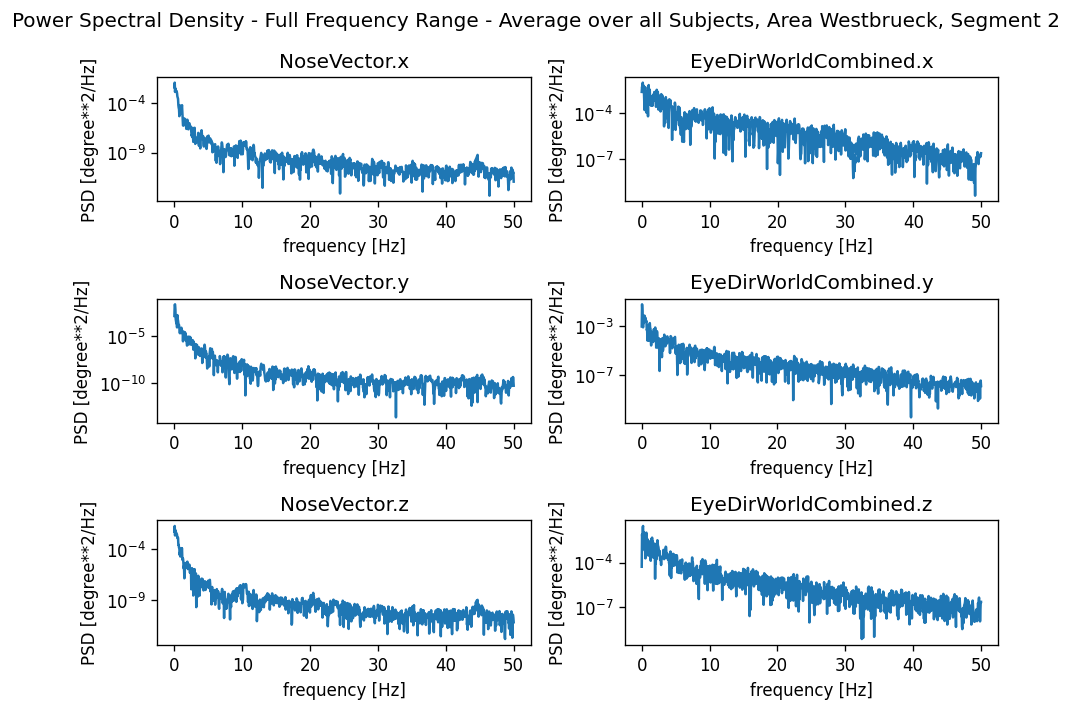

In [33]:
# power spectral density using welch's method, full frequency range 

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(8,6), dpi=120)

names_x = ["NoseVector.x","EyeDirWorldCombined.x","NoseVector.y","EyeDirWorldCombined.y","NoseVector.z","EyeDirWorldCombined.z"]

for idx, row in enumerate(ax.reshape(-1)):
    x = ((average_over_all_participants_single_segment[names_x[idx]] - 180) % 360) - 180
    x, index = reject_outliers(x)
    
    f, pxx_den = signal.welch(x,fs=(1/0.01),nperseg=2048)
    row.semilogy(f, pxx_den)
    #row.set_ylim([0.5e-3, 1])
    row.set_xlabel('frequency [Hz]')
    row.set_ylabel('PSD [degree**2/Hz]')
    row.set_title(names_x[idx])

fig.suptitle("Power Spectral Density - Full Frequency Range - Average over all Subjects, Area Westbrueck, Segment 2")
fig.tight_layout()
plt.show()

/Users/stefan/opt/anaconda3/envs/Body2Eye/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 2048 is greater than input length  = 1945, using nperseg = 1945
  warnings.warn('nperseg = {0:d} is greater than input length '
/Users/stefan/opt/anaconda3/envs/Body2Eye/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 2048 is greater than input length  = 2046, using nperseg = 2046
  warnings.warn('nperseg = {0:d} is greater than input length '
/Users/stefan/opt/anaconda3/envs/Body2Eye/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 2048 is greater than input length  = 2016, using nperseg = 2016
  warnings.warn('nperseg = {0:d} is greater than input length '
/Users/stefan/opt/anaconda3/envs/Body2Eye/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 2048 is greater than input length  = 2032, using nperseg = 2032
  warnings.warn('nperseg = {0:d} is greater than input l

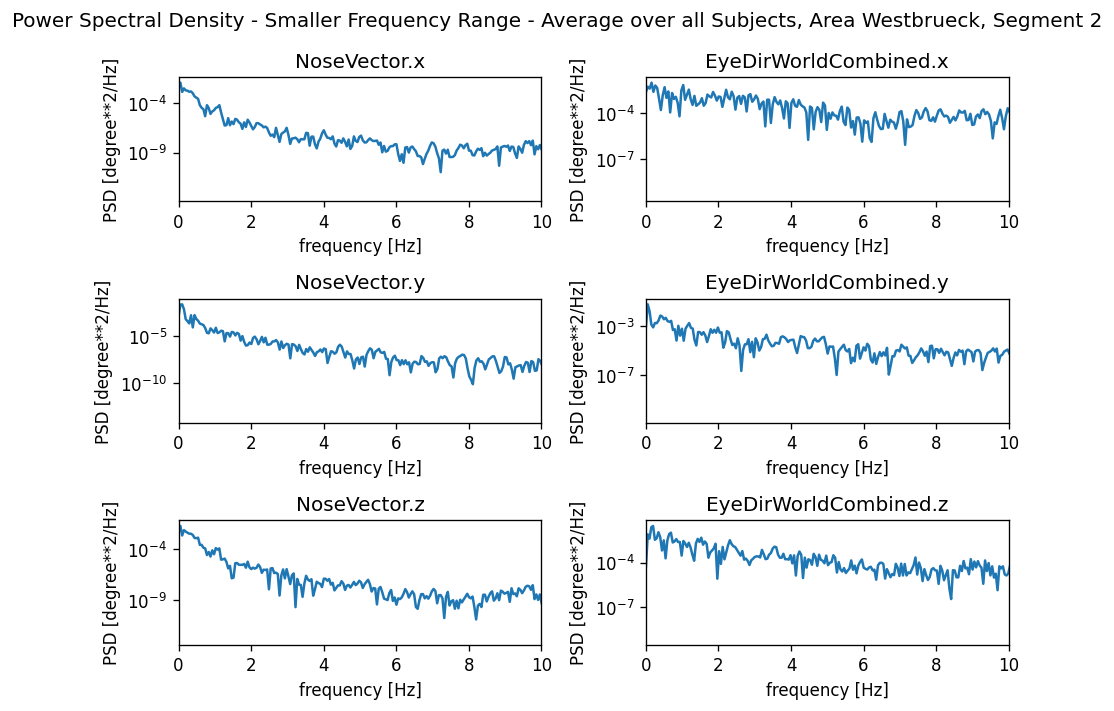

In [34]:
# power spectral density using welch's method, smaller frequency range

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(8,6), dpi=120)

names_x = ["NoseVector.x","EyeDirWorldCombined.x","NoseVector.y","EyeDirWorldCombined.y","NoseVector.z","EyeDirWorldCombined.z"]

for idx, row in enumerate(ax.reshape(-1)):
    
    x = ((average_over_all_participants_single_segment[names_x[idx]] - 180) % 360) - 180
    x, index = reject_outliers(x)
    
    f, pxx_den = signal.welch(x,fs=(1/0.01),nperseg=2048)
    row.semilogy(f, pxx_den)
    #row.set_ylim([0.5e-3, 1])
    row.set_xlabel('frequency [Hz]')
    row.set_ylabel('PSD [degree**2/Hz]')
    row.set_xlim(0,10)
    row.set_title(names_x[idx])

fig.suptitle("Power Spectral Density - Smaller Frequency Range - Average over all Subjects, Area Westbrueck, Segment 2")
fig.tight_layout()
plt.show()

## Cross spectral density

/Users/stefan/opt/anaconda3/envs/Body2Eye/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 2048 is greater than input length  = 2035, using nperseg = 2035
  warnings.warn('nperseg = {0:d} is greater than input length '
/Users/stefan/opt/anaconda3/envs/Body2Eye/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 2048 is greater than input length  = 2024, using nperseg = 2024
  warnings.warn('nperseg = {0:d} is greater than input length '
/Users/stefan/opt/anaconda3/envs/Body2Eye/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 2048 is greater than input length  = 2018, using nperseg = 2018
  warnings.warn('nperseg = {0:d} is greater than input length '


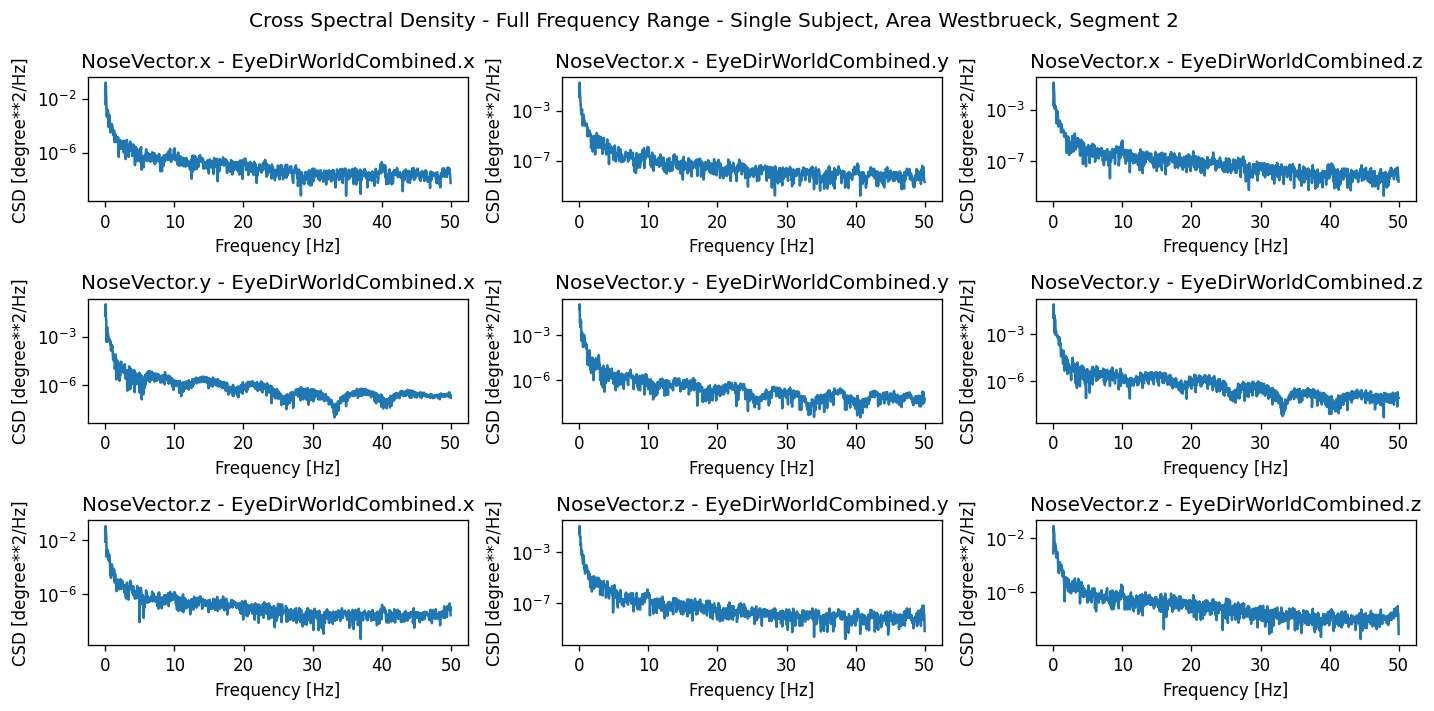

In [35]:
# csd full frequency range 

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12,6), dpi=120)

names_x = ["NoseVector.x","NoseVector.x","NoseVector.x","NoseVector.y","NoseVector.y","NoseVector.y","NoseVector.z","NoseVector.z","NoseVector.z"]
names_y = ["EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z","EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z","EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z"]

for idx, row in enumerate(ax.reshape(-1)):
        x = ((one_participant_single_segment[names_x[idx]][1:] - 180) % 360) - 180
        x, index = reject_outliers(x)
        y = ((one_participant_single_segment[names_y[idx]][1:] - 180) % 360) - 180
        y, yindex = reject_outliers(y)
        
        index_intersection = list(set(xindex).intersection(yindex))
        
        sample_freqs, csd = signal.csd(x,y,fs=(1/0.01),nperseg=2048)
        row.semilogy(sample_freqs, np.abs(csd))
        row.set_xlabel("Frequency [Hz]")
        row.set_ylabel("CSD [degree**2/Hz]")
        row.set_title(names_x[idx] + " - " + names_y[idx])

fig.suptitle("Cross Spectral Density - Full Frequency Range - Single Subject, Area Westbrueck, Segment 2")
fig.tight_layout()

plt.show()

/Users/stefan/opt/anaconda3/envs/Body2Eye/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 2048 is greater than input length  = 2011, using nperseg = 2011
  warnings.warn('nperseg = {0:d} is greater than input length '
/Users/stefan/opt/anaconda3/envs/Body2Eye/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 2048 is greater than input length  = 1998, using nperseg = 1998
  warnings.warn('nperseg = {0:d} is greater than input length '
/Users/stefan/opt/anaconda3/envs/Body2Eye/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 2048 is greater than input length  = 1955, using nperseg = 1955
  warnings.warn('nperseg = {0:d} is greater than input length '
/Users/stefan/opt/anaconda3/envs/Body2Eye/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 2048 is greater than input length  = 1989, using nperseg = 1989
  warnings.warn('nperseg = {0:d} is greater than input l

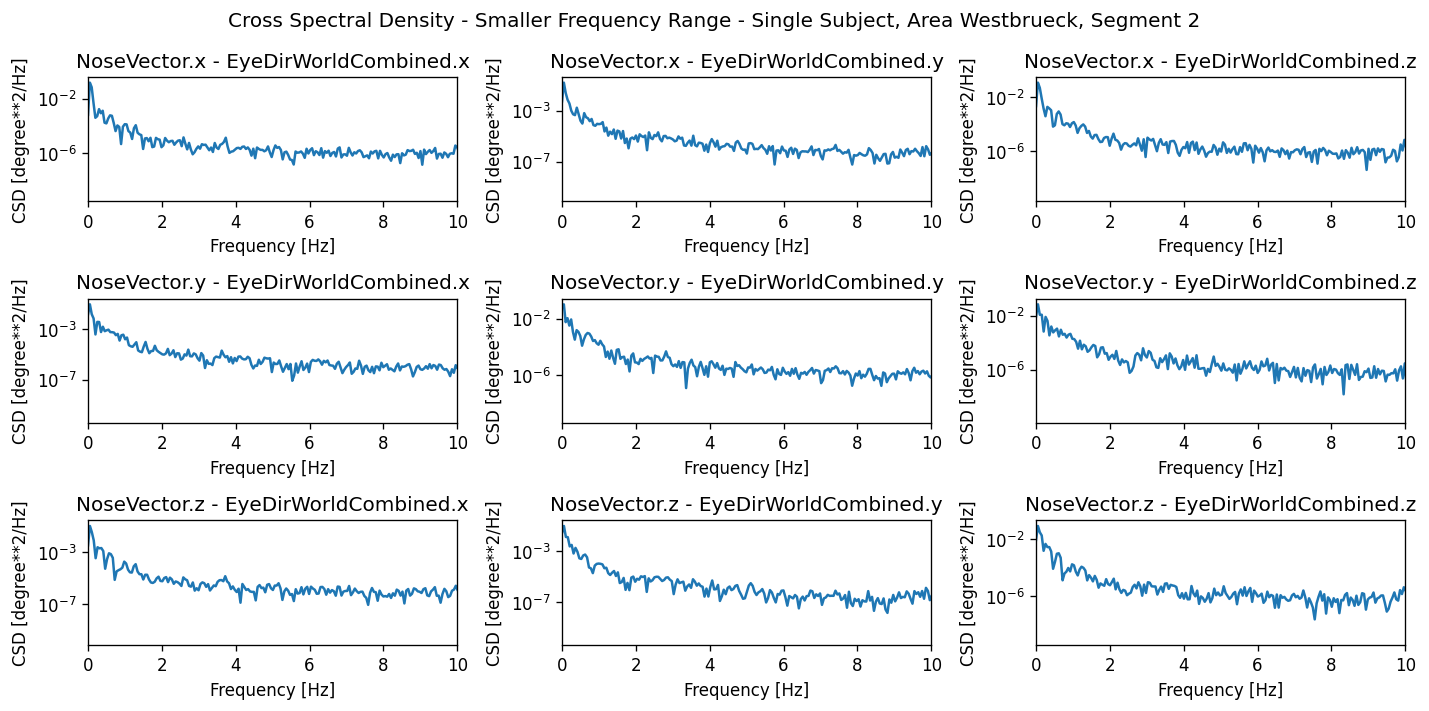

In [36]:
# csd smaller frequency range

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12,6), dpi=120)

names_x = ["NoseVector.x","NoseVector.x","NoseVector.x","NoseVector.y","NoseVector.y","NoseVector.y","NoseVector.z","NoseVector.z","NoseVector.z"]
names_y = ["EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z","EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z","EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z"]

for idx, row in enumerate(ax.reshape(-1)):
        x = ((one_participant_single_segment[names_x[idx]][1:] - 180) % 360) - 180
        x, xindex = reject_outliers(x)
        y = ((one_participant_single_segment[names_y[idx]][1:] - 180) % 360) - 180
        y, yindex = reject_outliers(y)
        
        index_intersection = list(set(xindex).intersection(yindex))
        
        sample_freqs, csd = signal.csd(x[index_intersection],y[index_intersection],fs=(1/0.01),nperseg=2048)
        row.semilogy(sample_freqs, np.abs(csd))
        row.set_xlabel("Frequency [Hz]")
        row.set_ylabel("CSD [degree**2/Hz]")
        row.set_xlim(0,10)
        row.set_title(names_x[idx] + " - " + names_y[idx])

fig.suptitle("Cross Spectral Density - Smaller Frequency Range - Single Subject, Area Westbrueck, Segment 2")
fig.tight_layout()

plt.show()

ValueError: x and y must have same first dimension, but have shapes (1025,) and (2, 1025)

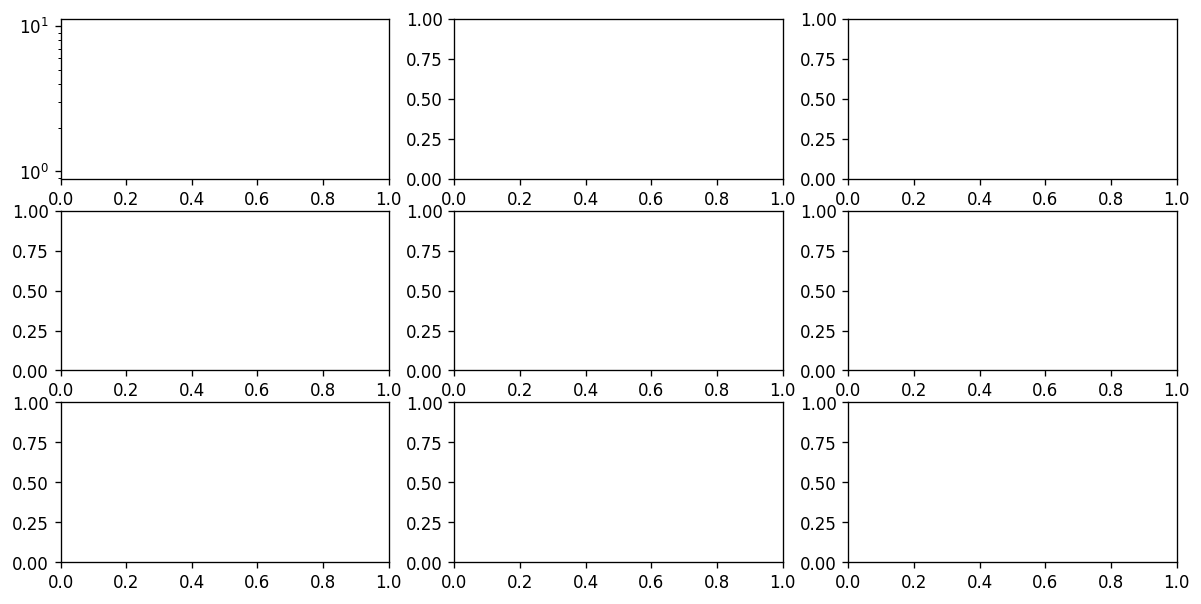

In [37]:
# csd full frequency range 

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12,6), dpi=120)

names_x = ["NoseVector.x","NoseVector.x","NoseVector.x","NoseVector.y","NoseVector.y","NoseVector.y","NoseVector.z","NoseVector.z","NoseVector.z"]
names_y = ["EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z","EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z","EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z"]

for idx, row in enumerate(ax.reshape(-1)):
        x = ((average_over_all_participants_single_segment[names_x[idx]][1:] - 180) % 360) - 180
        x = reject_outliers(x)
        y = ((average_over_all_participants_single_segment[names_y[idx]][1:] - 180) % 360) - 180
        y = reject_outliers(y)
        
        sample_freqs, csd = signal.csd(x,y,fs=(1/0.01),nperseg=2048)
        row.semilogy(sample_freqs, np.abs(csd))
        row.set_xlabel("Frequency [Hz]")
        row.set_ylabel("CSD [degree**2/Hz]")
        row.set_title(names_x[idx] + " - " + names_y[idx])

fig.suptitle("Cross Spectral Density - Full Frequency Range - Average over all Subjects, Area Westbrueck, Segment 2")
fig.tight_layout()

plt.show()

ValueError: x and y must have same first dimension, but have shapes (1025,) and (2, 1025)

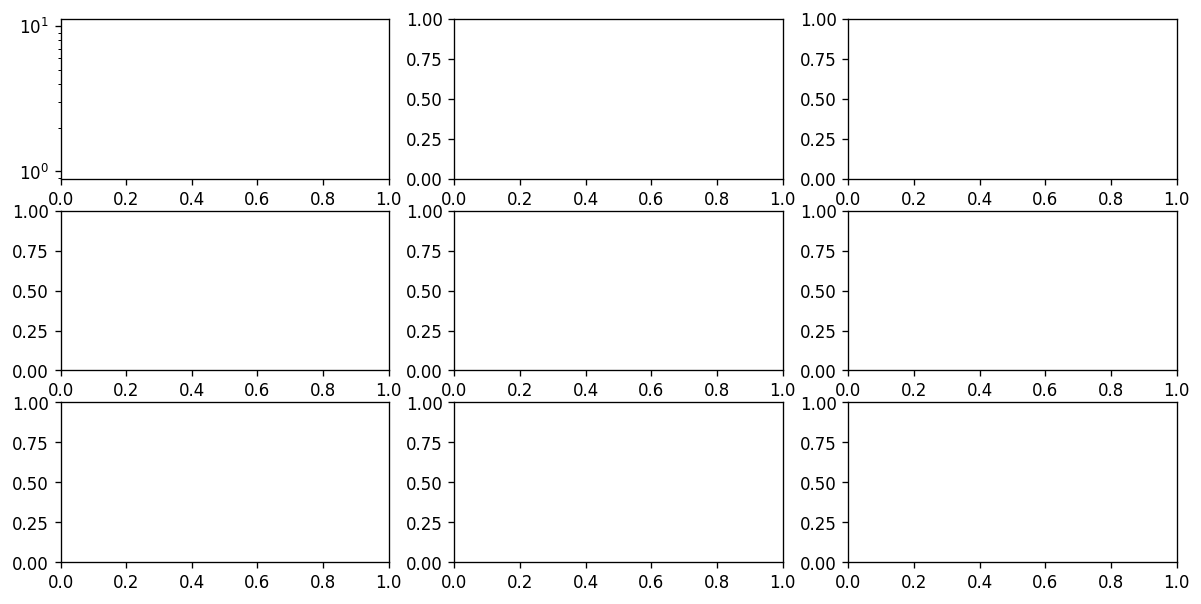

In [38]:
# csd smaller frequency range

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12,6), dpi=120)

names_x = ["NoseVector.x","NoseVector.x","NoseVector.x","NoseVector.y","NoseVector.y","NoseVector.y","NoseVector.z","NoseVector.z","NoseVector.z"]
names_y = ["EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z","EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z","EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z"]

for idx, row in enumerate(ax.reshape(-1)):

        x = ((average_over_all_participants_single_segment[names_x[idx]][1:] - 180) % 360) - 180
        x = reject_outliers(x)
        y = ((average_over_all_participants_single_segment[names_y[idx]][1:] - 180) % 360) - 180
        y = reject_outliers(y)
        
        sample_freqs, csd = signal.csd(x,y,fs=(1/0.01),nperseg=2048)
        row.semilogy(sample_freqs, np.abs(csd))
        row.set_xlabel("Frequency [Hz]")
        row.set_ylabel("CSD [degree**2/Hz]")
        row.set_xlim(0,10)
        row.set_title(names_x[idx] + " - " + names_y[idx])

fig.suptitle("Cross Spectral Density - Smaller Frequency Range - Average over all Subjects, Area Westbrueck, Segment 2")
fig.tight_layout()

plt.show()